## Abgabe Reinforcement Learning (30/07/2023)

## Links zu verwendeten Notebooks / Inspirationen:



Jupyter Notebooks used to (verwendet wurden um sich inspirieren zu lassen)

- https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/
- https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/
- https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/

Installation of needed Python Libraries:

In [2]:
!python -m pip install gym_super_mario_bros
!python -m pip install nes_py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.2 MB/s eta 0:00:00
  Created wheel for nes-py: filename=nes_py-8.2.1-cp310-cp310-linux_x86_64.whl size=535679 sha256=d25ca51d41fffa80edfe83c684ba847c8da32a2c0fff4fa3a4bf3f108a9bdbc9
  Stored in directory: /root/.cache/pip/wheels/34/a7/d5/9aa14b15df740a53d41f702e4c795731b6c4da7925deb8476c
Successfully built nes-py


In [3]:
# import libaries
import gym_super_mario_bros
from  nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT
import numpy as np
import pandas
import torch
import torch.nn as nn
import random
from tqdm import tqdm
import pickle
import collections
import cv2
import matplotlib.pyplot as plt
import time
import pylab as pl
import gym
from IPython import display
%matplotlib inline

In [4]:
# information about the environment
# https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/

env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
print('Dimensions of a frame: ', env.observation_space.shape)  # Dimensions of a frame - observation space  240 - height - 256 width , 3 color channels
print('Number of possible actions an agent can take: ',env.action_space.n)  # Number of actions our agent can take - 256 different actions
print('Simple moves an agent can take:', SIMPLE_MOVEMENT)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(


Dimensions of a frame:  (240, 256, 3)
Number of possible actions an agent can take:  256
Simple moves an agent can take: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


## Training eines DQN Agenten für die Super-Mario Umgebung

In [5]:
# code from : https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/
# https://blog.paperspace.com/building-double-deep-q-network-super-mario-bros/
# Code mit kleineren Anpassungen & Kommentaren
class MaxAndSkipEnv(gym.Wrapper):
    """
        Each action of the agent is repeated over skip frames
        return only every `skip`-th frame
    """
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action) # create environment and make actions
            self._obs_buffer.append(obs) # append observations to buffer
            total_reward += reward # safe current reward to total reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        """Clear past frame buffer and init to first obs"""
        self._obs_buffer.clear() # delete past buffer (memory of experiences)
        obs = self.env.reset() # reset environment
        self._obs_buffer.append(obs) # append new observations to buffer
        return obs


class MarioRescale84x84(gym.ObservationWrapper):
    """
    Downsamples/Rescales each frame to size 84x84 with greyscale
    Preprocess environment
  Reducing the video frame size,
    """
    def __init__(self, env=None):
        super(MarioRescale84x84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8) # reduce observation space to different size

    def observation(self, obs):
        return MarioRescale84x84.process(obs) # create a new scaled environment

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        # image normalization on RBG
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

class ImageToPyTorch(gym.ObservationWrapper):
    """
    Each frame is converted to PyTorch tensors
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class BufferWrapper(gym.ObservationWrapper):
    """
    Only every k-th frame is collected by the buffer
    """
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


class PixelNormalization(gym.ObservationWrapper):
    """
    Normalize pixel values in frame --> 0 to 1
    """
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0


def create_mario_env(env):
  # Preprocess environment before training the agent
    env = MaxAndSkipEnv(env)
    env = MarioRescale84x84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = PixelNormalization(env)
    return JoypadSpace(env, SIMPLE_MOVEMENT)

class DQNSolver(nn.Module):
    """
    Convolutional Neural Net with 3 conv layers and two linear layers
    """
    def __init__(self, input_shape, n_actions):
        super(DQNSolver, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)


class DQNAgent:

    def __init__(self, state_space, action_space, max_memory_size, batch_size, gamma, lr,
                 dropout, exploration_max, exploration_min, exploration_decay, double_dqn, pretrained):

        # Define DQN Layers
        self.state_space = state_space
        self.action_space = action_space
        self.double_dqn = double_dqn
        self.pretrained = pretrained
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        # Double DQN network
        if self.double_dqn:
            self.local_net = DQNSolver(state_space, action_space).to(self.device)
            self.target_net = DQNSolver(state_space, action_space).to(self.device)

            if self.pretrained:
                self.local_net.load_state_dict(torch.load("DQN1.pt", map_location=torch.device(self.device)))
                self.target_net.load_state_dict(torch.load("DQN2.pt", map_location=torch.device(self.device)))

            self.optimizer = torch.optim.Adam(self.local_net.parameters(), lr=lr)
            self.copy = 5000  # Copy the local model weights into the target network every 5000 steps
            self.step = 0
        # DQN network
        else:
            self.dqn = DQNSolver(state_space, action_space).to(self.device)

            if self.pretrained:
                self.dqn.load_state_dict(torch.load("DQN.pt", map_location=torch.device(self.device)))
            self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)

        # Create memory to save actions, reward and states
        self.max_memory_size = max_memory_size
        if self.pretrained:
            self.STATE_MEM = torch.load("STATE_MEM.pt")
            self.ACTION_MEM = torch.load("ACTION_MEM.pt")
            self.REWARD_MEM = torch.load("REWARD_MEM.pt")
            self.STATE2_MEM = torch.load("STATE2_MEM.pt")
            self.DONE_MEM = torch.load("DONE_MEM.pt")
            with open("ending_position.pkl", 'rb') as f:
                self.ending_position = pickle.load(f)
            with open("num_in_queue.pkl", 'rb') as f:
                self.num_in_queue = pickle.load(f)
        else:
            self.STATE_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.ACTION_MEM = torch.zeros(max_memory_size, 1)
            self.REWARD_MEM = torch.zeros(max_memory_size, 1)
            self.STATE2_MEM = torch.zeros(max_memory_size, *self.state_space)
            self.DONE_MEM = torch.zeros(max_memory_size, 1)
            self.ending_position = 0
            self.num_in_queue = 0

        self.memory_sample_size = batch_size

        # Learning parameters
        self.gamma = gamma
        self.l1 = nn.SmoothL1Loss().to(self.device) # Also known as Huber loss
        self.exploration_max = exploration_max
        self.exploration_rate = exploration_max
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay

    def remember(self, state, action, reward, state2, done):
        """Store the experiences in a buffer to use later"""
        self.STATE_MEM[self.ending_position] = state.float()
        self.ACTION_MEM[self.ending_position] = action.float()
        self.REWARD_MEM[self.ending_position] = reward.float()
        self.STATE2_MEM[self.ending_position] = state2.float()
        self.DONE_MEM[self.ending_position] = done.float()
        self.ending_position = (self.ending_position + 1) % self.max_memory_size  # FIFO tensor
        self.num_in_queue = min(self.num_in_queue + 1, self.max_memory_size)

    def batch_experiences(self):
        """Randomly sample 'batch size' experiences"""
        idx = random.choices(range(self.num_in_queue), k=self.memory_sample_size)
        STATE = self.STATE_MEM[idx]
        ACTION = self.ACTION_MEM[idx]
        REWARD = self.REWARD_MEM[idx]
        STATE2 = self.STATE2_MEM[idx]
        DONE = self.DONE_MEM[idx]
        return STATE, ACTION, REWARD, STATE2, DONE

    def act(self, state):
        """Epsilon-greedy action"""
        if self.double_dqn:
            self.step += 1
        if random.random() < self.exploration_rate:
            return torch.tensor([[random.randrange(self.action_space)]])
        if self.double_dqn:
            # Local net is used for the policy
            return torch.argmax(self.local_net(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()
        else:
            return torch.argmax(self.dqn(state.to(self.device))).unsqueeze(0).unsqueeze(0).cpu()

    def copy_model(self):
        """Copy local net weights into target net for DDQN network"""
        self.target_net.load_state_dict(self.local_net.state_dict())

    def experience_replay(self):
        """Use the double Q-update or Q-update equations to update the network weights"""
        if self.double_dqn and self.step % self.copy == 0:
            self.copy_model()

        if self.memory_sample_size > self.num_in_queue:
            return

        # Sample a batch of experiences
        STATE, ACTION, REWARD, STATE2, DONE = self.batch_experiences()
        STATE = STATE.to(self.device)
        ACTION = ACTION.to(self.device)
        REWARD = REWARD.to(self.device)
        STATE2 = STATE2.to(self.device)
        DONE = DONE.to(self.device)

        self.optimizer.zero_grad()
        if self.double_dqn:
            # Double Q-Learning target is Q*(S, A) <- r + γ max_a Q_target(S', a)
            target = REWARD + torch.mul((self.gamma * self.target_net(STATE2).max(1).values.unsqueeze(1)),  1 - DONE)

            current = self.local_net(STATE).gather(1, ACTION.long()) # Local net approximation of Q-value
        else:
            # Q-Learning target is Q*(S, A) <- r + γ max_a Q(S', a)
            target = REWARD + torch.mul((self.gamma * self.dqn(STATE2).max(1).values.unsqueeze(1)), 1 - DONE)

            current = self.dqn(STATE).gather(1, ACTION.long())

        loss = self.l1(current, target)
        loss.backward() # Compute gradients
        self.optimizer.step() # Backpropagate error

        self.exploration_rate *= self.exploration_decay

        # Makes sure that exploration rate is always at least 'exploration min'
        self.exploration_rate = max(self.exploration_rate, self.exploration_min)

def show_state(env, ep=0, info=""):
    """While testing show the mario playing environment"""
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: %d %s" % (ep, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

def run(training_mode, pretrained, double_dqn, num_episodes=1000, exploration_max=1):

    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0') # create a new environment
    env = create_mario_env(env)  # Wraps the environment so that frames are grayscale
    observation_space = env.observation_space.shape # get shape of environment
    action_space = env.action_space.n
    agent = DQNAgent(state_space=observation_space,
                     action_space=action_space,
                     max_memory_size=30000,
                     batch_size=32,
                     gamma=0.90,
                     lr=0.00025,
                     dropout=0.2,
                     exploration_max=1.0,
                     exploration_min=0.02,
                     exploration_decay=0.99,
                     double_dqn=double_dqn,
                     pretrained=pretrained) # built an dqn agent for super mario

    # Restart the enviroment for each episode
    num_episodes = num_episodes
    env.reset() # reset environment before start of training

    total_rewards = []
    if training_mode and pretrained:
        with open("total_rewards.pkl", 'rb') as f:
            total_rewards = pickle.load(f)

    for ep_num in tqdm(range(num_episodes)):
        state = env.reset() # reset environment before a new episode starts
        state = torch.Tensor([state])
        total_reward = 0
        steps = 0
        while True:
            if not training_mode:
                show_state(env, ep_num)
            action = agent.act(state)
            steps += 1

            state_next, reward, terminal, info = env.step(int(action[0])) # save reward, and next state
            total_reward += reward # save reward in total rewards to maximize it
            state_next = torch.Tensor([state_next])
            reward = torch.tensor([reward]).unsqueeze(0)

            terminal = torch.tensor([int(terminal)]).unsqueeze(0)

            if training_mode:
                agent.remember(state, action, reward, state_next, terminal)
                agent.experience_replay()

            state = state_next
            if terminal:
                break

        total_rewards.append(total_reward)

        if ep_num != 0 and ep_num % 100 == 0:
            print("Episode {} score = {}, average score = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))
        num_episodes += 1

        print("Episode {} score = {}, average score = {}".format(ep_num + 1, total_rewards[-1], np.mean(total_rewards)))

    # Save the trained memory so that we can continue from where we stop using 'pretrained' = True
    if training_mode:
        with open("ending_position.pkl", "wb") as f:
            pickle.dump(agent.ending_position, f)
        with open("num_in_queue.pkl", "wb") as f:
            pickle.dump(agent.num_in_queue, f)
        with open("total_rewards.pkl", "wb") as f:
            pickle.dump(total_rewards, f)
        if agent.double_dqn:
            torch.save(agent.local_net.state_dict(), "DQN1.pt")
            torch.save(agent.target_net.state_dict(), "DQN2.pt")
        else:
            torch.save(agent.dqn.state_dict(), "DQN.pt")
        torch.save(agent.STATE_MEM,  "STATE_MEM.pt")
        torch.save(agent.ACTION_MEM, "ACTION_MEM.pt")
        torch.save(agent.REWARD_MEM, "REWARD_MEM.pt")
        torch.save(agent.STATE2_MEM, "STATE2_MEM.pt")
        torch.save(agent.DONE_MEM,   "DONE_MEM.pt")

    env.close()


In [6]:
# Training the RL Agent
# Code from : https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/
run(training_mode=True, pretrained=False, double_dqn=True, num_episodes=10, exploration_max = 1)


  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-5-bbb162615310>:314: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  state = torch.Tensor([state])
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
 10%|█         | 1/10 [00:13<02:03, 13.70s/it]

Episode 1 score = 597.0, average score = 597.0


 20%|██        | 2/10 [00:20<01:18,  9.80s/it]

Episode 2 score = 599.0, average score = 598.0


 30%|███       | 3/10 [00:22<00:42,  6.11s/it]

Episode 3 score = 232.0, average score = 476.0


 40%|████      | 4/10 [00:24<00:26,  4.34s/it]

Episode 4 score = 231.0, average score = 414.75


 50%|█████     | 5/10 [00:25<00:15,  3.19s/it]

Episode 5 score = 231.0, average score = 378.0


 60%|██████    | 6/10 [00:26<00:10,  2.51s/it]

Episode 6 score = 231.0, average score = 353.5


 70%|███████   | 7/10 [00:34<00:13,  4.47s/it]

Episode 7 score = 557.0, average score = 382.57142857142856


 80%|████████  | 8/10 [00:36<00:07,  3.51s/it]

Episode 8 score = 232.0, average score = 363.75


 90%|█████████ | 9/10 [00:38<00:02,  2.96s/it]

Episode 9 score = 229.0, average score = 348.77777777777777


100%|██████████| 10/10 [00:39<00:00,  3.93s/it]

Episode 10 score = 241.0, average score = 338.0


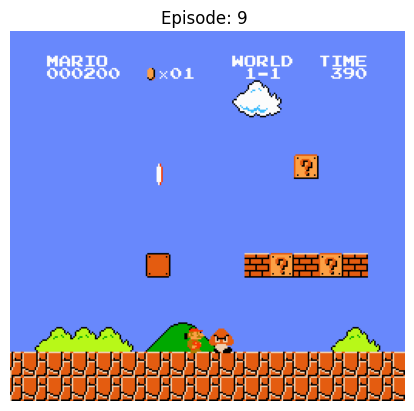

100%|██████████| 10/10 [11:24<00:00, 68.45s/it]

Episode 10 score = 219.0, average score = 546.2


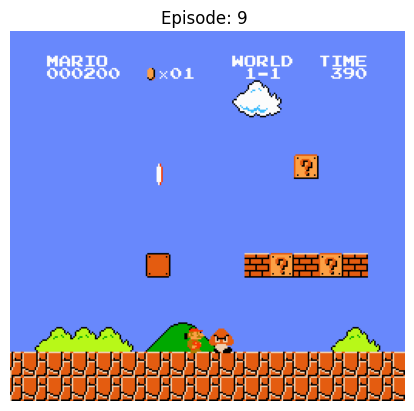

In [7]:
# Testing the RL Agent
# Code from : https://www.analyticsvidhya.com/blog/2021/06/playing-super-mario-bros-with-deep-reinforcement-learning/
run(training_mode=False, pretrained=True, double_dqn=True, num_episodes=10, exploration_max = 0.05)

## Visualization of rewards:

I realized too late that I can not access the reward for this reason I used the output scores to visualize them.

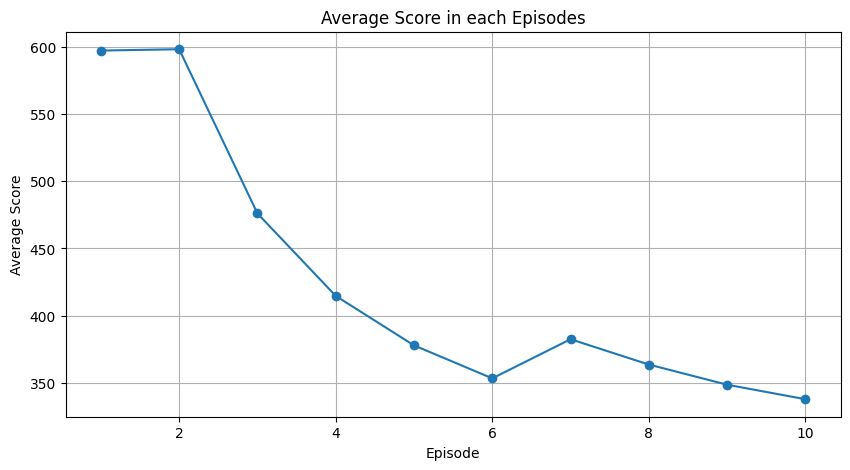

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# List of average scores
average_scores = [597.0, 598.0, 476.0, 414.75, 378.0, 353.5, 382.57142857142856, 363.75, 348.77777777777777, 338.0]

#  array with the number of episodes
episodes = np.arange(len(average_scores)) + 1

plt.figure(figsize=(10, 5))
plt.plot(episodes, average_scores, marker='o', linestyle='-')
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.title('Average Score in each Episodes')
plt.grid(True)
plt.show()

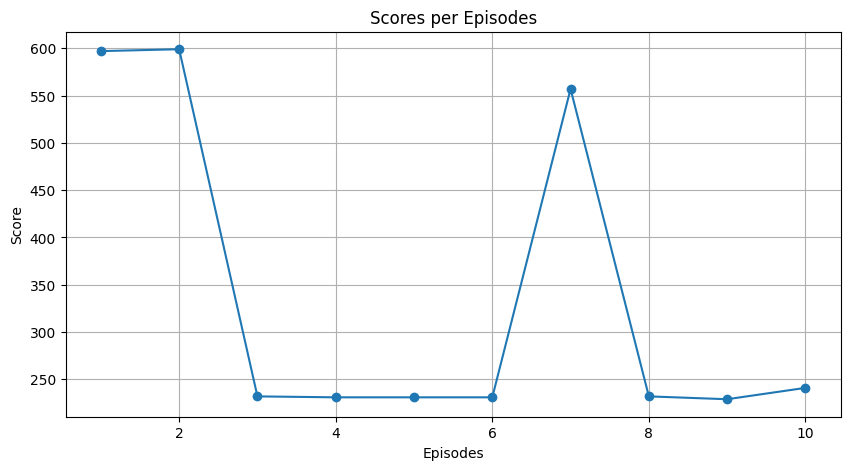

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# actual scores listed above
scores = [597.0, 599.0, 232.0, 231.0, 231.0, 231.0, 557.0, 232.0, 229.0, 241.0]

# Create an array with the number of episodes
episodes = np.arange(len(scores)) + 1

plt.figure(figsize=(10, 5))
plt.plot(episodes, scores, marker='o', linestyle='-')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.title('Scores per Episodes')
plt.grid(True)
plt.show()